In [1]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision.transforms as t
import os
import cv2
import torch
from PIL import Image

class SegmentationDataset(Dataset):
    
    def __init__(self, imgs_dir, masks_dir):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        
        self.imgs_paths = os.listdir(self.imgs_dir)
        self.imgs_paths.sort()
        
        self.masks_paths = os.listdir(self.masks_dir)
        self.masks_paths.sort()
        
    def __len__(self):
        return len(self.imgs_paths)
    
    def __getitem__(self, idx, size=(512, 512)):
        
        img = cv2.imread(os.path.join(self.imgs_dir, self.imgs_paths[idx]))
        img = Image.fromarray(img)
        img_actions = t.Compose([t.Resize(size),
                              t.RandomRotation(degrees=(0, 180)), 
                              t.RandomPerspective(distortion_scale=0.6, p=1.0),
                              t.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                             t.ToTensor(),
                             t.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ])
        img = img_actions(img)
      
        mask = cv2.imread(os.path.join(self.masks_dir, self.masks_paths[idx]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (512, 512))
        mask = torch.from_numpy(mask).long()
                
        return img, mask

In [2]:
train_dataset = SegmentationDataset("./dataset_sample/original_images/", "./dataset_sample/label_images_semantic/")

In [3]:
val_dataset = SegmentationDataset("./dataset_sample/original_images/", "./dataset_sample/label_images_semantic/")

In [4]:
batch_size = 3

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) 

In [5]:
import segmentation_models_pytorch as smp

model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23)

In [6]:
for param in model.encoder.parameters():
    param.requires_grad = True

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)

Using device: cpu


In [8]:
from torch.nn import CrossEntropyLoss

epoch_count = 10

loss_fn = CrossEntropyLoss()

In [21]:
learning_rate = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
import torch.nn.functional as F

def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [23]:
from tqdm import tqdm

cont_training = 7
train_losses = []
train_acc = []
max_acc = 0
min_loss = np.inf
val_losses = []
val_acc = []

    
for epoch in range(epoch_count):
    print(f"Epoch {epoch+1} / {epoch_count}\n-------------------------------")
    train_accuracy = 0
    train_loss = 0
    
    for batch_num, (img_batch, mask_batch) in enumerate(tqdm(train_loader)):

        img_batch = img_batch.to(device) 
        mask_batch = mask_batch.to(device)
    
        output_batch = model(img_batch)
        loss_value = loss_fn(output_batch, mask_batch)
        train_loss += loss_value.item()
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()           
    
        train_accuracy += pixel_accuracy(output_batch, mask_batch)
                
    else:
        
        val_loss = 0
        val_accuracy = 0
        
        with torch.no_grad():

            for batch_num, (img_batch, mask_batch) in enumerate(tqdm(val_loader)):

                img_batch = img_batch.to(device) 
                mask_batch = mask_batch.to(device)

                output_batch = model(img_batch)
                val_loss_value = loss_fn(output_batch, mask_batch)
                val_loss += val_loss_value.item()

                val_accuracy += pixel_accuracy(output_batch, mask_batch)        
                
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        train_acc.append(train_accuracy/len(train_loader))
        val_acc.append(val_accuracy/len(val_loader))       
                
                   
    if val_accuracy > max_acc:
        max_acc = val_accuracy
        model_to_save = {
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'accuracy': val_accuracy,
                            }
                   
    if val_loss_value > min_loss:
        cont_training -= 1
        min_loss = val_loss_value
        if not cont_training:
            print('Stop training')
            break
                
         
                
    print(f"train loss = {train_loss/len(train_loader)} | accuracy = {train_accuracy/len(train_loader)}")
    print(f"val loss = {val_loss/len(val_loader)} | accuracy = {val_accuracy/len(val_loader)}")
    torch.save(model_to_save, 'model.pt')
    
        

Epoch 1 / 10
-------------------------------


100%|████████████████████████████████████████████| 3/3 [00:15<00:00,  5.13s/it]


train loss = 1.9769563277562459 | accuracy = 0.43284861246744794
val loss = 1.944899360338847 | accuracy = 0.44289398193359375
Epoch 2 / 10
-------------------------------


100%|████████████████████████████████████████████| 3/3 [00:15<00:00,  5.20s/it]


train loss = 1.9608789682388306 | accuracy = 0.44742902119954425
val loss = 1.935100515683492 | accuracy = 0.4655689663357205
Epoch 3 / 10
-------------------------------


100%|████████████████████████████████████████████| 3/3 [00:16<00:00,  5.41s/it]


train loss = 1.9120680093765259 | accuracy = 0.4638693067762587
val loss = 1.9531515041987102 | accuracy = 0.44742902119954425
Epoch 4 / 10
-------------------------------


100%|████████████████████████████████████████████| 3/3 [00:15<00:00,  5.27s/it]


train loss = 1.9526398181915283 | accuracy = 0.44742902119954425
val loss = 1.959132194519043 | accuracy = 0.4394217597113715
Epoch 5 / 10
-------------------------------


100%|████████████████████████████████████████████| 3/3 [00:16<00:00,  5.53s/it]


train loss = 1.8654393752415974 | accuracy = 0.48541620042588973
val loss = 1.9887312253316243 | accuracy = 0.4411214192708333
Epoch 6 / 10
-------------------------------


100%|████████████████████████████████████████████| 3/3 [00:17<00:00,  5.77s/it]


train loss = 1.8869458039601643 | accuracy = 0.4739146762424045
val loss = 1.9474901755650837 | accuracy = 0.4299761454264323
Epoch 7 / 10
-------------------------------


100%|████████████████████████████████████████████| 3/3 [00:17<00:00,  5.76s/it]


train loss = 1.9728219509124756 | accuracy = 0.4491286807590061
val loss = 1.9617644945780437 | accuracy = 0.4526229434543186
Epoch 8 / 10
-------------------------------


100%|████████████████████████████████████████████| 3/3 [00:17<00:00,  5.96s/it]


train loss = 1.9149071375528972 | accuracy = 0.45090124342176646
val loss = 1.916374683380127 | accuracy = 0.4609686533610026
Epoch 9 / 10
-------------------------------


100%|████████████████████████████████████████████| 3/3 [00:15<00:00,  5.29s/it]


train loss = 1.964348832766215 | accuracy = 0.4394217597113716
val loss = 1.9000898202260335 | accuracy = 0.4739146762424045
Epoch 10 / 10
-------------------------------


100%|████████████████████████████████████████████| 3/3 [00:16<00:00,  5.49s/it]

train loss = 1.8874547084172566 | accuracy = 0.46734152899848086
val loss = 1.9646495978037517 | accuracy = 0.43167580498589414


In [24]:
import matplotlib.pyplot as plt
def plot(train_data, val_data, label ):
    plt.plot(train_data, label='train', marker='o')
    plt.plot(val_data, label='val', marker='o')  
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

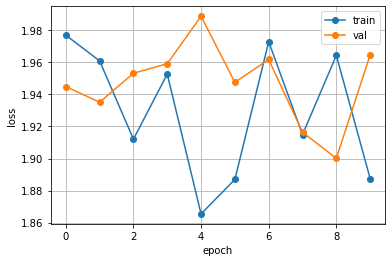

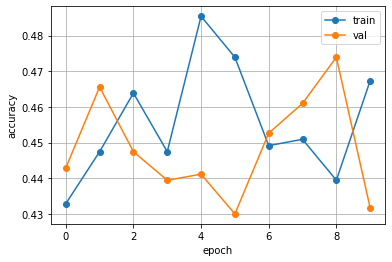

In [25]:
plot(train_losses, val_losses, 'loss')
plot(train_acc, val_acc, 'accuracy')